In [1]:
import tensorflow as tf
import os

In [2]:
#Avoid OOM errors by setting gpu memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [4]:
data_dir = 'data'
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [5]:
img = cv2.imread(os.path.join('data', 'Cobra', 'image_143.jpg'))
print(img.shape)
print(img)

(450, 900, 3)
[[[250 248 247]
  [250 248 247]
  [250 248 247]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[250 248 247]
  [250 248 247]
  [250 248 247]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[250 248 247]
  [250 248 247]
  [250 248 247]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[228 230 230]
  [228 230 230]
  [228 230 230]
  ...
  [226 227 225]
  [226 227 225]
  [226 227 225]]

 [[228 230 230]
  [228 230 230]
  [228 230 230]
  ...
  [226 226 226]
  [226 226 226]
  [226 226 226]]

 [[228 230 230]
  [228 230 230]
  [228 230 230]
  ...
  [226 226 226]
  [226 226 226]
  [226 226 226]]]


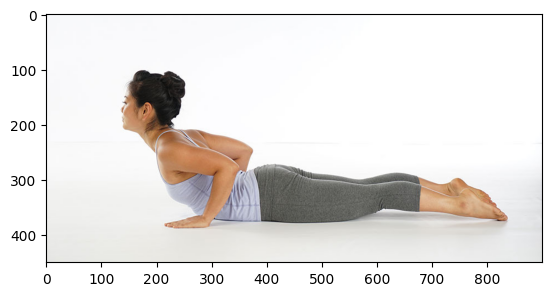

In [6]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [8]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1000 files belonging to 5 classes.


In [9]:
data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

In [12]:
batch[1]

array([0, 0, 4, 0, 1, 3, 1, 0, 2, 4, 0, 4, 1, 0, 2, 4, 2, 3, 4, 4, 3, 1,
       3, 3, 1, 2, 4, 4, 2, 0, 1, 1])

0 - Chair
1 - Cobra
2 - Downdog
3 - Low Lunge
4 - Side Plamk

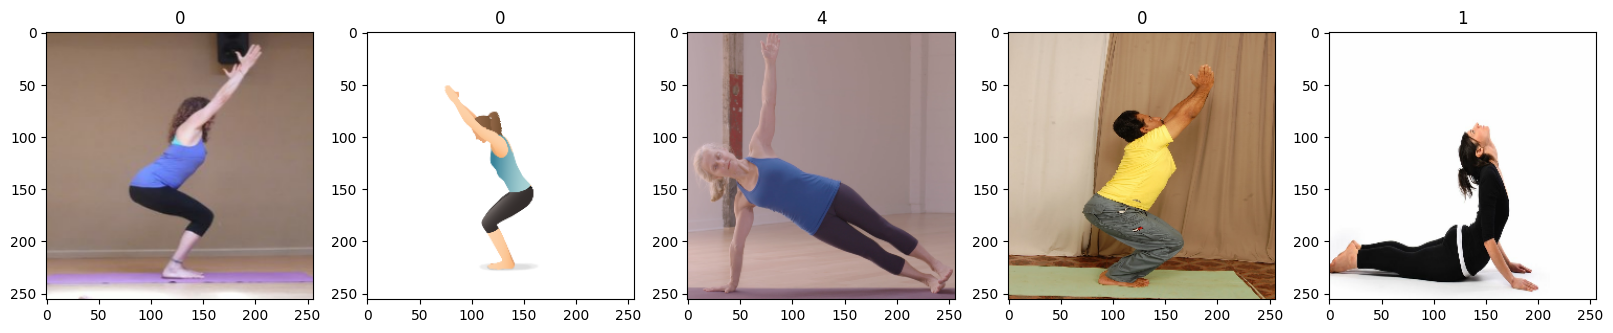

In [13]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [14]:
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [15]:
batch = data.as_numpy_iterator().next()

In [16]:
batch[0].min()

0.0

In [17]:
#data - 32
train_size = int(len(data)*.7) #22
val_size = int(len(data)*.2) #6
test_size = int(len(data)*.1)+1 #3

In [18]:
test_size

4

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

train_it = train.as_numpy_iterator().next()
val_it = val.as_numpy_iterator().next()
test_it = test.as_numpy_iterator().next()

x_train = train_it[0]
y_train = train_it[1]
x_val = val_it[0]
y_val = val_it[1]
x_test = test_it[0]
y_test = test_it[1]

In [20]:
from tensorflow.keras import datasets, layers, models

In [29]:
model = models.Sequential()

In [30]:
model.add(layers.Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(32, (3,3), 1, activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, (3,3), 1, activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [31]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 64)      

In [33]:
hist = model.fit(train, epochs=30, validation_data=val)

Epoch 1/30
22/22 [==============================] - 51s 2s/step - loss: 2.3857 - accuracy: 0.2685 - val_loss: 1.4655 - val_accuracy: 0.5000
Epoch 2/30
22/22 [==============================] - 49s 2s/step - loss: 1.2997 - accuracy: 0.4901 - val_loss: 1.2513 - val_accuracy: 0.5208
Epoch 3/30
22/22 [==============================] - 57s 3s/step - loss: 1.0266 - accuracy: 0.6250 - val_loss: 0.8887 - val_accuracy: 0.6875
Epoch 4/30
22/22 [==============================] - 55s 2s/step - loss: 0.7064 - accuracy: 0.7443 - val_loss: 0.6939 - val_accuracy: 0.7708
Epoch 5/30
22/22 [==============================] - 55s 2s/step - loss: 0.4714 - accuracy: 0.8438 - val_loss: 0.5326 - val_accuracy: 0.8385
Epoch 6/30
22/22 [==============================] - 50s 2s/step - loss: 0.2724 - accuracy: 0.9233 - val_loss: 0.4488 - val_accuracy: 0.8750
Epoch 7/30
22/22 [==============================] - 48s 2s/step - loss: 0.1676 - accuracy: 0.9517 - val_loss: 0.4916 - val_accuracy: 0.8594
Epoch 8/30
22/22 [==

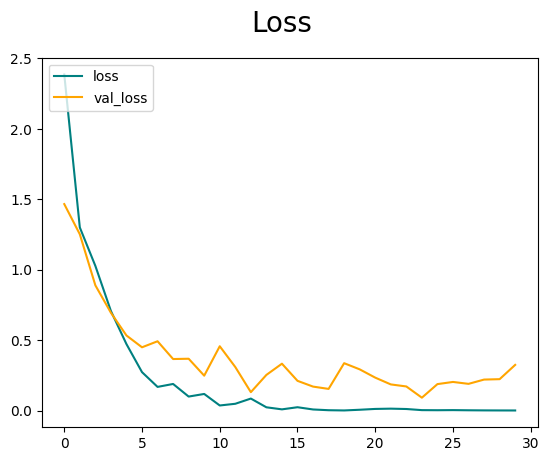

In [35]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

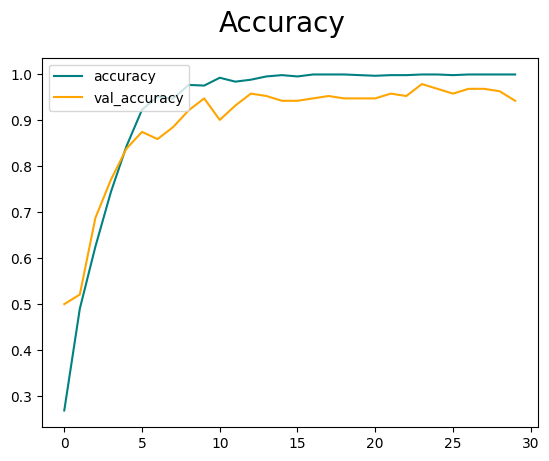

In [36]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [37]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [38]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
model.evaluate(test)

4/4 [==============================] - 6s 243ms/step - loss: 0.0951 - accuracy: 0.9808


[0.09508045017719269, 0.9807692170143127]

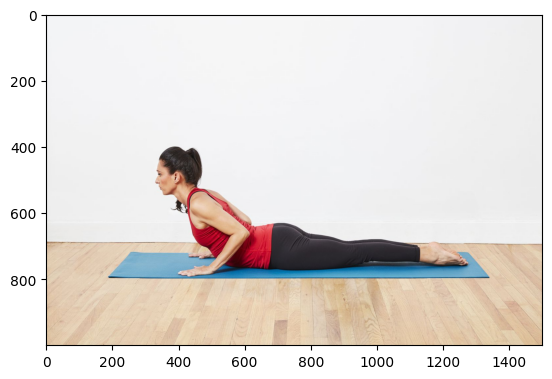

In [96]:
img = cv2.imread('img2.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

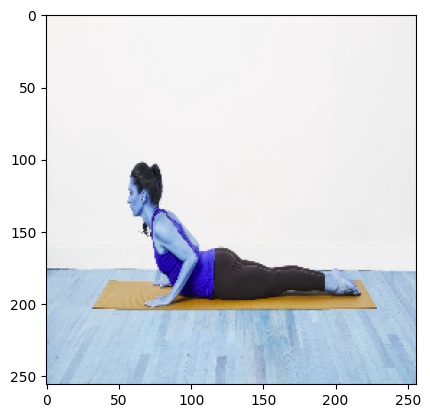

In [97]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [98]:
ypred = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 52ms/step


In [99]:
ypred

array([[1.6211234e-07, 9.9999344e-01, 1.7894019e-08, 3.5540415e-06,
        2.7925482e-06]], dtype=float32)

In [100]:
yclass = [np.argmax(element) for element in ypred]

In [101]:
if ypred[0][yclass] < 0.8:
    print('Try Again')
else:
    print(yclass)

[1]


In [34]:
from tensorflow.keras.models import load_model

In [102]:
model.save(os.path.join('models','mulcls.h5'))